In [5]:
# 解压数据脚本，将文件解压到work目录下
!unzip -q -d  /home/aistudio/work /home/aistudio/data/data150537/insects.zip

replace /home/aistudio/work/insects/test/images/2077.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# 昆虫类名
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

def get_insect_names():
    """
    return a dict, as following,
        {'Boerner': 0,
         'Leconte': 1,
         'Linnaeus': 2, 
         'acuminatus': 3,
         'armandi': 4,
         'coleoptera': 5,
         'linnaeus': 6
        }
    It can map the insect name into an integer label.
    """
    insect_category2id = {}
    for i, item in enumerate(INSECT_NAMES):
        insect_category2id[item] = i
    return insect_category2id

In [30]:
cname2cid = get_insect_names()
cname2cid

{'Boerner': 0,
 'Leconte': 1,
 'Linnaeus': 2,
 'acuminatus': 3,
 'armandi': 4,
 'coleoptera': 5,
 'linnaeus': 6}

In [31]:
import os
import numpy as np
import xml.etree.ElementTree as ET

# 从annotations/xml目录下面读取所有文件标注信息
def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, 'annotations', 'xmls'))
    records = []
    ct = 0
    for fname in filenames:
        fid = fname.split('.')[0]
        fpath = os.path.join(datadir, 'annotations', 'xmls', fname)
        if os.path.isdir(fpath):
            continue
        img_file = os.path.join(datadir, 'images', fid + '.jpeg')
        tree = ET.parse(fpath)

        if tree.find('id') is None:
            im_id = np.array([ct])
        else:
            im_id = np.array([int(tree.find('id').text)])

        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), ), dtype=np.int32)
        is_crowd = np.zeros((len(objs), ), dtype=np.int32)
        difficult = np.zeros((len(objs), ), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        voc_rec = {
            'im_file': img_file,  # 图片路径
            'im_id': im_id,  # 图片标识符
            'h': im_h,  # 图片高度
            'w': im_w,  # 图片宽度
            'is_crowd': is_crowd,  # 目标物体是否为拥挤目标（0表示非拥挤，1表示拥挤）
            'gt_class': gt_class,  # 目标物体的类别ID
            'gt_bbox': gt_bbox,  # 目标物体的边界框坐标，格式为 [中心点x, 中心点y, 宽度, 高度]
            'gt_poly': [],  # 目标物体的多边形坐标（这里为空）
            'difficult': difficult  # 目标物体的困难程度标记（0表示非困难，1表示困难）
            }
        if len(objs) != 0:
            records.append(voc_rec)
        ct += 1
    return records

In [32]:
TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

print('records num:{}\n recored[0]:{}'.format(len(records), records[0]))

records num:1693
 recored[0]:{'im_file': '/home/aistudio/work/insects/train/images/1095.jpeg', 'im_id': array([0]), 'h': 1204.0, 'w': 1204.0, 'is_crowd': array([0, 0, 0, 0, 0, 0], dtype=int32), 'gt_class': array([1, 6, 3, 4, 6, 0], dtype=int32), 'gt_bbox': array([[857. , 517. , 115. ,  69. ],
       [609.5, 525. ,  60. ,  93. ],
       [566.5, 630. ,  38. ,  53. ],
       [583.5, 730.5,  68. ,  68. ],
       [695.5, 646.5,  76. ,  48. ],
       [721.5, 778.5, 146. ,  70. ]], dtype=float32), 'gt_poly': [], 'difficult': array([0, 0, 0, 0, 0, 0], dtype=int32)}


In [33]:
# 数据读取
import cv2

# 处理图像中的目标检测标注信息，将其标准化为一个固定大小的数组
def get_bbox(gt_bbox, gt_class):
    # 对于一般的检测任务来说，一张图片上往往会有多个目标物体
    # 设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实
    # 框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i, :] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >= MAX_NUM:
            break
    return gt_bbox2, gt_class2

def get_img_data_from_file(record):
    """
    record is a dict as following,
      record = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
    """
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 将图像从BGR格式转换为RGB格式

    # check if h and w in record equals that read from img
    assert img.shape[0] == int(h), \
             "image height of {} inconsistent in record({}) and img file({})".format(
               im_file, h, img.shape[0])

    assert img.shape[1] == int(w), \
             "image width of {} inconsistent in record({}) and img file({})".format(
               im_file, w, img.shape[1])

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)
  
    return img, gt_boxes, gt_labels, (h, w)

In [11]:
record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
print('img shape:{}, \n get_boxes;{} \n gt_labels:{}, \n scales:{}\n'.format(img.shape, gt_boxes, gt_labels, scales))

img shape:(1230, 1230, 3), 
 get_boxes;[[0.52195122 0.50284553 0.0902439  0.04715447]
 [0.58170732 0.51260163 0.03739837 0.06341463]
 [0.63211382 0.68130081 0.10569106 0.1195122 ]
 [0.52479675 0.31463415 0.07317073 0.1097561 ]
 [0.71707317 0.5703252  0.05447154 0.05203252]
 [0.33577236 0.59796748 0.07235772 0.06341463]
 [0.62764228 0.37317073 0.10162602 0.08373984]
 [0.52154472 0.62479675 0.10569106 0.09918699]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.      

read image from file /home/aistudio/work/insects/train/images/1095.jpeg


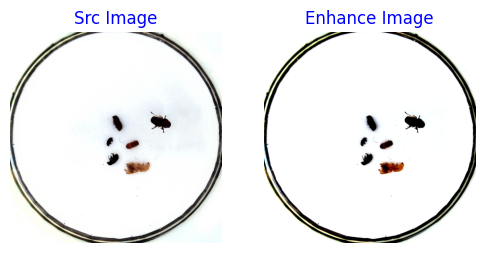

In [34]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import random

# 随机改变亮暗、对比度和颜色等
def random_distort(img):
    # 随机改变亮度
    def random_brightness(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Brightness(img).enhance(e)
    # 随机改变对比度
    def random_contrast(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Contrast(img).enhance(e)
    # 随机改变颜色
    def random_color(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Color(img).enhance(e)

    ops = [random_brightness, random_contrast, random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img)

    return img

# 定义可视化函数，用于对比原图和图像增强的效果
import matplotlib.pyplot as plt
%matplotlib inline
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6,12))
    plt.subplot(1,2,1)
    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    # 对原图做 随机改变亮暗、对比度和颜色等 数据增强
    srcimg_gtbox = records[0]['gt_bbox']
    srcimg_label = records[0]['gt_class']

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)


image_path = records[0]['im_file']
print("read image from file {}".format(image_path))
srcimg = Image.open(image_path)
# 将PIL读取的图像转换成array类型
srcimg = np.array(srcimg)

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_distort(srcimg)
visualize(srcimg, img_enhance)

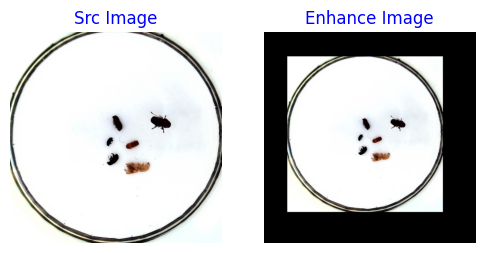

In [35]:
# 随机填充
def random_expand(img,
                  gtboxes,
                  max_ratio=4.,
                  fill=None,
                  keep_ratio=True,
                  thresh=0.5):
    if random.random() > thresh:
        return img, gtboxes

    if max_ratio < 1.0:
        return img, gtboxes

    h, w, c = img.shape
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow - w)
    off_y = random.randint(0, oh - h)

    out_img = np.zeros((oh, ow, c))
    if fill and len(fill) == c:
        for i in range(c):
            out_img[:, :, i] = fill[i] * 255.0

    out_img[off_y:off_y + h, off_x:off_x + w, :] = img
    gtboxes[:, 0] = ((gtboxes[:, 0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return out_img.astype('uint8'), gtboxes

srcimg_gtbox = records[0]['gt_bbox']
srcimg_label = records[0]['gt_class']

img_enhance, new_gtbox = random_expand(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

src image shape:(1204, 1204, 3), resize imgage shape:(640, 640, 3)


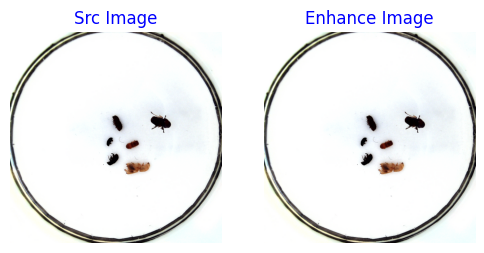

In [36]:
# 随机缩放
def random_interp(img, size, interp=None):
    interp_method = [
        cv2.INTER_NEAREST,
        cv2.INTER_LINEAR,
        cv2.INTER_AREA,
        cv2.INTER_CUBIC,
        cv2.INTER_LANCZOS4,
    ]
    if not interp or interp not in interp_method:
        interp = interp_method[random.randint(0, len(interp_method) - 1)]
    h, w, _ = img.shape
    im_scale_x = size / float(w)
    im_scale_y = size / float(h)
    img = cv2.resize(
        img, None, None, fx=im_scale_x, fy=im_scale_y, interpolation=interp)
    return img

# 对原图做 随机缩放
random_size = 640
img_enhance = random_interp(srcimg, random_size)
visualize(srcimg, img_enhance)
print('src image shape:{}, resize imgage shape:{}'.format(srcimg.shape, img_enhance.shape))

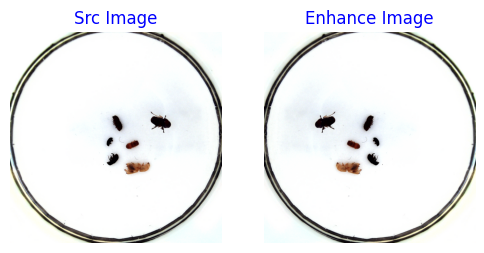

In [37]:
# 随机翻转
def random_flip(img, gtboxes, thresh=0.5):
    if random.random() > thresh:
        img = img[:, ::-1, :]
        gtboxes[:, 0] = 1.0 - gtboxes[:, 0]
    return img, gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance, box_enhance = random_flip(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

In [38]:
# 随机打乱真实框排列顺序
def shuffle_gtbox(gtbox, gtlabel):
    gt = np.concatenate(
        [gtbox, gtlabel[:, np.newaxis]], axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx, :]
    return gt[:, :4], gt[:, 4]

[2024-06-17 19:45:58,719] [ WARNING] image.py:701 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


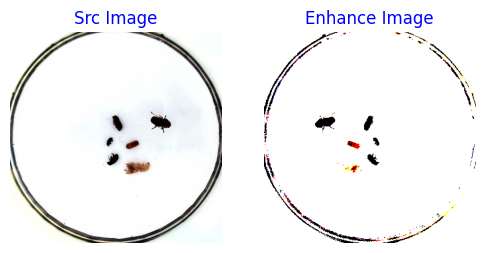

In [39]:
# 图像增广方法汇总
def image_augment(img, gtboxes, gtlabels, size, means=None):
    # 随机改变亮暗、对比度和颜色等
    img = random_distort(img)
    # 随机填充
    img, gtboxes = random_expand(img, gtboxes, fill=means)
    # 随机缩放
    img = random_interp(img, size)
    # 随机翻转
    img, gtboxes = random_flip(img, gtboxes)
    # 随机打乱真实框排列顺序
    gtboxes, gtlabels = shuffle_gtbox(gtboxes, gtlabels)

    return img.astype('float32'), gtboxes.astype('float32'), gtlabels.astype('int32')

img_enhance, img_box, img_label = image_augment(srcimg, srcimg_gtbox, srcimg_label, size=320)
visualize(srcimg, img_enhance)

In [18]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
print('img shape:{}\n gt_boxes shape:{}\n gt_labels shape:{}'.format(img.shape, gt_boxes.shape, gt_labels.shape))

img shape:(512, 512, 3)
 gt_boxes shape:(50, 4)
 gt_labels shape:(50,)


In [40]:
# img数据数值需要调整，需要除以255，并且减去均值和方差，再将维度从[H, W, C]调整为[C, H, W]
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = np.array(mean).reshape((1, 1, -1))  # 将mean的形状变为(1,1,3)
std = np.array(std).reshape((1, 1, -1))  # 将std的形状变为(1,1,3)
img = (img / 255.0 - mean) / std
img = img.astype('float32').transpose((2, 0, 1))
print('img shape:{}'.format(img.shape))

img shape:(3, 512, 512)


In [41]:
# 将上面的过程整理成一个get_img_data函数
def get_img_data(record, size=640):
    img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
    img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    img = (img / 255.0 - mean) / std
    img = img.astype('float32').transpose((2, 0, 1))
    return img, gt_boxes, gt_labels, scales

In [42]:
TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data(record, size=480)
print('img shape:{} \n gt_boxes:{}\n gt_bales:{}\n scales:{}'.format(img.shape, gt_boxes, gt_labels, scales))

img shape:(3, 480, 480) 
 gt_boxes:[[1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.6393849  0.31448412 0.05357143 0.08234127]
 [1.         0.         0.         0.        ]
 [0.42857143 0.5793651  0.07242063 0.05456349]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.6651786  0.6423611  0.0515873  0.12103175]
 [1.         0.         0.         0.        ]
 [0.51289684 0.42212301 0.04265873 0.04761905]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.51289684 0.6130952  0.04861111 0.04265873]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0

In [43]:
# 获取一个批次内样本随机缩放的尺寸
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 320 + ii * 32
    else:
        img_size = 608
    return img_size

# 将 list形式的batch数据 转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data], dtype = 'float32')
    gt_box_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    gt_labels_array = np.array([item[2] for item in batch_data], dtype = 'int32')
    img_scale = np.array([item[3] for item in batch_data], dtype='int32')
    return img_array, gt_box_array, gt_labels_array, img_scale

In [44]:
import paddle

# 定义数据读取类，继承Paddle.io.Dataset
class TrainDataset(paddle.io.Dataset):
    def  __init__(self, datadir, mode='train'):
        self.datadir = datadir
        cname2cid = get_insect_names()
        self.records = get_annotations(cname2cid, datadir)
        self.img_size = 640  #get_img_size(mode)

    def __getitem__(self, idx):
        record = self.records[idx]
        # print("print: ", record)
        img, gt_bbox, gt_labels, im_shape = get_img_data(record, size=self.img_size)

        return img, gt_bbox, gt_labels, np.array(im_shape)

    def __len__(self):
        return len(self.records)

# 创建数据读取类
train_dataset = TrainDataset(TRAINDIR, mode='train')

# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
train_loader = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)

In [24]:
img, gt_boxes, gt_labels, im_shape = next(train_loader())
print('img shape:{}\n gt_boxes shape:{}\n gt_labels shape:{}'.format(img.shape, gt_boxes.shape, gt_labels.shape))

img shape:[2, 3, 640, 640]
 gt_boxes shape:[2, 50, 4]
 gt_labels shape:[2, 50]


[2024-06-17 19:49:31,906] [ WARNING] dataloader_iter.py:707 - DataLoader 2 workers exit unexpectedly, pids: 7008, 7010


In [45]:
import os
# 将 list形式的batch数据 转化成多个array构成的tuple
def make_test_array(batch_data):
    img_name_array = np.array([item[0] for item in batch_data])
    img_data_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    img_scale_array = np.array([item[2] for item in batch_data], dtype='int32')
    return img_name_array, img_data_array, img_scale_array

# 测试数据读取
def test_data_loader(datadir, batch_size= 1, test_image_size=608, mode='test'):
    """
    加载测试用的图片，测试数据没有groundtruth标签
    """
    image_names = os.listdir(datadir)
    def reader():
        batch_data = []
        img_size = test_image_size
        for image_name in image_names:
            file_path = os.path.join(datadir, image_name)
            if os.path.isdir(file_path):
                continue
            img = cv2.imread(file_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H = img.shape[0]
            W = img.shape[1]
            img = cv2.resize(img, (img_size, img_size))

            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            mean = np.array(mean).reshape((1, 1, -1))
            std = np.array(std).reshape((1, 1, -1))
            out_img = (img / 255.0 - mean) / std
            out_img = out_img.astype('float32').transpose((2, 0, 1))
            img = out_img #np.transpose(out_img, (2,0,1))
            im_shape = [H, W]

            batch_data.append((image_name.split('.')[0], img, im_shape))
            if len(batch_data) == batch_size:
                yield make_test_array(batch_data)
                batch_data = []
        if len(batch_data) > 0:
            yield make_test_array(batch_data)

    return reader

In [46]:
from yolo import YOLOv3

In [47]:
def get_loss(num_classes, outputs, gtbox, gtlabel, gtscore=None,
                anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326],
                anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
                ignore_thresh=0.7,
                use_label_smooth=False):
    """
    使用paddle.vision.ops.yolo_loss
    """
    losses = []
    downsample = 32
    for i, out in enumerate(outputs): # 对三个层级分别求损失函数
        anchor_mask_i = anchor_masks[i]
        loss = paddle.vision.ops.yolo_loss(
                x=out,  # out是P0, P1, P2中的一个
                gt_box=gtbox,  # 真实框坐标
                gt_label=gtlabel,  # 真实框类别
                gt_score=gtscore,  # 真实框得分，使用mixup训练技巧时需要，不使用该技巧时直接设置为1，形状与gtlabel相同
                anchors=anchors,   # 锚框尺寸，包含[w0, h0, w1, h1, ..., w8, h8]共9个锚框的尺寸
                anchor_mask=anchor_mask_i, # 筛选锚框的mask，例如anchor_mask_i=[3, 4, 5]，将anchors中第3、4、5个锚框挑选出来给该层级使用
                class_num=num_classes, # 分类类别数
                ignore_thresh=ignore_thresh, # 当预测框与真实框IoU > ignore_thresh，标注objectness = -1
                downsample_ratio=downsample, # 特征图相对于原图缩小的倍数，例如P0是32， P1是16，P2是8
                use_label_smooth=False)      # 使用label_smooth训练技巧时会用到，这里没用此技巧，直接设置为False
        losses.append(paddle.mean(loss))  #mean对每张图片求和
        downsample = downsample // 2 # 下一级特征图的缩放倍数会减半
    return sum(losses) # 对每个层级求和

In [28]:
# 用于生成一个分段衰减的学习率调度器，在第10000步时，学习率会从初始值变为衰减后的值，在第20000步时，学习率会再次衰减
def get_lr(base_lr = 0.0001, lr_decay = 0.1):
    bd = [10000, 20000]
    lr = [base_lr, base_lr * lr_decay, base_lr * lr_decay * lr_decay]
    learning_rate = paddle.optimizer.lr.PiecewiseDecay(boundaries=bd, values=lr)
    return learning_rate

In [29]:
############# 这段代码在本地机器上运行请慎重，容易造成死机，我们可以使用较小的MAX_EPOCH运行#######################

import time
import os
import paddle

# MAX_EPOCH = 200
MAX_EPOCH = 20

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]

ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

IGNORE_THRESH = .7
NUM_CLASSES = 7

TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
paddle.set_device("gpu:0")
# 创建数据读取类
train_dataset = TrainDataset(TRAINDIR, mode='train')
valid_dataset = TrainDataset(VALIDDIR, mode='valid')
test_dataset = TrainDataset(VALIDDIR, mode='valid')
# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
train_loader = paddle.io.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, drop_last=True, use_shared_memory=False)
valid_loader = paddle.io.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0, drop_last=False, use_shared_memory=False)
model = YOLOv3(num_classes = NUM_CLASSES)  #创建模型
learning_rate = get_lr()
opt = paddle.optimizer.Momentum(
                learning_rate=learning_rate,
                momentum=0.9,
                weight_decay=paddle.regularizer.L2Decay(0.0005),
                parameters=model.parameters())  #创建优化器
# opt = paddle.optimizer.Adam(learning_rate=learning_rate, weight_decay=paddle.regularizer.L2Decay(0.0005), parameters=model.parameters())


if __name__ == '__main__':
    for epoch in range(MAX_EPOCH):
        for i, data in enumerate(train_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)  #前向传播，输出[P0, P1, P2]
            loss = get_loss(NUM_CLASSES, outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)        # 计算损失函数

            loss.backward()    # 反向传播计算梯度
            opt.step()  # 更新参数
            opt.clear_grad()
            if i % 10 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[TRAIN]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))

        # save params of model
        if (epoch % 5 == 0) or (epoch == MAX_EPOCH -1):
            paddle.save(model.state_dict(), 'yolo_epoch{}'.format(epoch))

        # 每个epoch结束之后在验证集上进行测试
        model.eval()
        for i, data in enumerate(valid_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)
            loss = get_loss(NUM_CLASSES,outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)
            if i % 1 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[VALID]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))
        model.train()

ValueError: The device should not be <re.Match object; span=(0, 5), match='gpu:0'>, since PaddlePaddle is not compiled with CUDA

In [48]:
# 计算IoU，矩形框的坐标形式为xyxy，这个函数会被保存在box_utils.py文件中
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou

# 非极大值抑制
# 按得分降序排序候选框。
# 遍历候选框，保留得分高于score_thresh的候选框。
# 对于每个候选框，计算与已保留框的IoU，如果IoU大于nms_thresh，则抑制该候选框。
# 返回保留的候选框的索引。
def nms(bboxes, scores, score_thresh, nms_thresh, pre_nms_topk, i=0, c=0):
    """
    nms
    """
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds) > 0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        # if score of the box is less than score_thresh, just drop it
        if cur_score < score_thresh:
            break

        keep = True
        for ind in keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box, remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if i == 0 and c == 4 and cur_ind == 951:
            print('suppressed, ', keep, i, c, cur_ind, ind, iou)
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]

    return np.array(keep_inds)

# 多分类非极大值抑制
# 对于每个批次，分别处理每个类别的候选框。
# 对每个类别的候选框，应用NMS，保留筛选后的候选框。
# 将保留的候选框的类别标签、得分和坐标合并。
# 如果筛选后的候选框数量超过pos_nms_topk，则按得分降序保留前pos_nms_topk个候选框。
# 返回每个批次的筛选结果。
def multiclass_nms(bboxes, scores, score_thresh=0.01, nms_thresh=0.45, pre_nms_topk=1000, pos_nms_topk=100):
    """
    This is for multiclass_nms
    """
    batch_size = bboxes.shape[0]
    class_num = scores.shape[1]
    rets = []
    for i in range(batch_size):
        bboxes_i = bboxes[i]
        scores_i = scores[i]
        ret = []
        for c in range(class_num):
            scores_i_c = scores_i[c]
            keep_inds = nms(bboxes_i, scores_i_c, score_thresh, nms_thresh, pre_nms_topk, i=i, c=c)
            if len(keep_inds) < 1:
                continue
            keep_bboxes = bboxes_i[keep_inds]
            keep_scores = scores_i_c[keep_inds]
            keep_results = np.zeros([keep_scores.shape[0], 6])
            keep_results[:, 0] = c
            keep_results[:, 1] = keep_scores[:]
            keep_results[:, 2:6] = keep_bboxes[:, :]
            ret.append(keep_results)
        if len(ret) < 1:
            rets.append(ret)
            continue
        ret_i = np.concatenate(ret, axis=0)
        scores_i = ret_i[:, 1]
        if len(scores_i) > pos_nms_topk:
            inds = np.argsort(scores_i)[::-1]
            inds = inds[:pos_nms_topk]
            ret_i = ret_i[inds]

        rets.append(ret_i)

    return rets

In [ ]:
import json
import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]

ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

VALID_THRESH = 0.01

NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45

NUM_CLASSES = 7

# 在验证集val上评估训练模型
TESTDIR = '/home/aistudio/work/insects/val/images' #请将此目录修改成用户自己保存测试图片的路径
WEIGHT_FILE = '/home/aistudio/yolo_epoch10' # 请将此文件名修改成用户自己训练好的权重参数存放路径


# 在测试集test上评估训练模型
# TESTDIR = '/home/aistudio/work/insects/test/images'
# WEIGHT_FILE = '/home/aistudio/yolo_epoch0'

if __name__ == '__main__':
    model = YOLOv3(num_classes=NUM_CLASSES)
    params_file_path = WEIGHT_FILE
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)
    model.eval()

    total_results = []
    test_loader = test_data_loader(TESTDIR, batch_size= 1, mode='test')
    for i, data in enumerate(test_loader()):
        img_name, img_data, img_scale_data = data
        img = paddle.to_tensor(img_data)
        img_scale = paddle.to_tensor(img_scale_data)

        outputs = model.forward(img)
        bboxes, scores = model.get_pred(outputs,
                                 im_shape=img_scale,
                                 anchors=ANCHORS,
                                 anchor_masks=ANCHOR_MASKS,
                                 valid_thresh = VALID_THRESH)

        bboxes_data = bboxes.numpy()
        scores_data = scores.numpy()
        result = multiclass_nms(bboxes_data, scores_data,
                      score_thresh=VALID_THRESH, 
                      nms_thresh=NMS_THRESH, 
                      pre_nms_topk=NMS_TOPK, 
                      pos_nms_topk=NMS_POSK)
        for j in range(len(result)):
            result_j = result[j]
            img_name_j = img_name[j]
            total_results.append([img_name_j, result_j.tolist()])
        print('processed {} pictures'.format(len(total_results)))

    print('')
    json.dump(total_results, open('pred_results.json', 'w'))

In [ ]:
import os
import json
import numpy as np
import xml.etree.ElementTree as ET
from map_utils import DetectionMAP

# 存放测试集标签的目录
annotations_dir ="/home/aistudio/work/insects/val/annotations/xmls"

# 存放预测结果的文件
pred_result_file = "pred_results.json"
# pred_result_file 中保存着测试结果，是包含所有图片预测结果的list，其构成如下
# [[img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]], 
#  [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]],
#  ...
#  [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]]]
# list中的每一个元素是一张图片的预测结果，list的总长度等于图片的数目
# 每张图片预测结果的格式是: [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]]
# 其中第一个元素是图片名称image_name，第二个元素是包含所有预测框的列表
# 预测框列表中每个元素[label, score, x1, x2, y1, y2]描述了一个预测框，
# label是预测框所属类别标签，score是预测框的得分
# x1, x2, y1, y2对应预测框左上角坐标(x1, y1)，右下角坐标(x2, y2)
# 每张图片可能有很多个预测框，则将其全部放在预测框列表中

overlap_thresh = 0.5
map_type = '11point'
insect_names = ['Boerner', 'Leconte', 'Linnaeus', 'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

if __name__ == '__main__':
    cname2cid = {}
    for i, item in enumerate(insect_names):
        cname2cid[item] = i
    filename = pred_result_file
    results = json.load(open(filename))
    num_classes = len(insect_names)
    detection_map = DetectionMAP(class_num=num_classes,
                        overlap_thresh=overlap_thresh,
                        map_type=map_type,
                        is_bbox_normalized=False,
                        evaluate_difficult=False)
    for result in results:
        image_name = str(result[0])
        bboxes = np.array(result[1]).astype('float32')
        anno_file = os.path.join(annotations_dir, image_name + '.xml')
        tree = ET.parse(anno_file)
        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), 1), dtype=np.int32)
        difficult = np.zeros((len(objs), 1), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i][0] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            gt_bbox[i] = [x1, y1, x2, y2]
            difficult[i][0] = _difficult
        detection_map.update(bboxes, gt_bbox, gt_class, difficult)

    print("Accumulating evaluatation results...")
    detection_map.accumulate()
    map_stat = 100. * detection_map.get_map()
    print("mAP({:.2f}, {}) = {:.2f}".format(overlap_thresh,
                            map_type, map_stat))

In [49]:
import json
import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]
ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
VALID_THRESH = 0.01
NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45

NUM_CLASSES = 7
image_name = '/home/aistudio/work/insects/test/images/'
params_file_path = '/home/aistudio/yolo_epoch10'

model = YOLOv3(num_classes=NUM_CLASSES)
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)
model.eval()

total_results = []
test_loader = test_data_loader(image_name, batch_size=1, mode='test')
for i, data in enumerate(test_loader()):
    img_name, img_data, img_scale_data = data
    print(img_name)
    img = paddle.to_tensor(img_data)
    img_scale = paddle.to_tensor(img_scale_data)

    outputs = model.forward(img)
    bboxes, scores = model.get_pred(outputs,
                                im_shape=img_scale,
                                anchors=ANCHORS,
                                anchor_masks=ANCHOR_MASKS,
                                valid_thresh = VALID_THRESH)

    bboxes_data = bboxes.numpy()
    scores_data = scores.numpy()
    results = multiclass_nms(bboxes_data, scores_data,
                    score_thresh=VALID_THRESH, 
                    nms_thresh=NMS_THRESH, 
                    pre_nms_topk=NMS_TOPK, 
                    pos_nms_topk=NMS_POSK)
    # 将结果保存到 total_results
    total_results.append({
        'img_name': img_name,
        'results': results
    })

print('/home/aistudio/work/insects/test/images/'+str(total_results[0]['img_name'][0])+'.jpeg')

['2564']
['2600']
['2565']
['2697']
['2570']
['3184']
['2583']
['3114']
['2028']
['2251']
['3069']
['2077']
['3179']
['2258']
['3102']
['1957']
['3106']
['3188']
['2483']
['3100']
['2736']
['3128']
['3153']
['2015']
['1875']
['1895']
['1975']
['3093']
['3104']
['2558']
['1993']
['2523']
['2031']
['2592']
['3177']
['2643']
['3077']
['2551']
['2555']
['2739']
['2599']
['2625']
['2227']
['2067']
['2226']
['3181']
['1880']


KeyboardInterrupt: 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画图函数
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

# 定义画矩形框的函数 
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

# 定义绘制预测结果的函数
def draw_results(result, filename, draw_thresh=0.5):
    plt.figure(figsize=(10, 10))
    im = cv2.imread(filename)
    plt.imshow(im)
    currentAxis=plt.gca()
    colors = ['r', 'g', 'b', 'k', 'y', 'c', 'purple']
    for item in result:
        box = item[2:6]
        label = int(item[0])
        name = INSECT_NAMES[label]
        if float(item[1]) > draw_thresh:
            draw_rectangle(currentAxis, box, edgecolor = colors[label])
            plt.text(box[0], box[1], name, fontsize=12, color=colors[label])

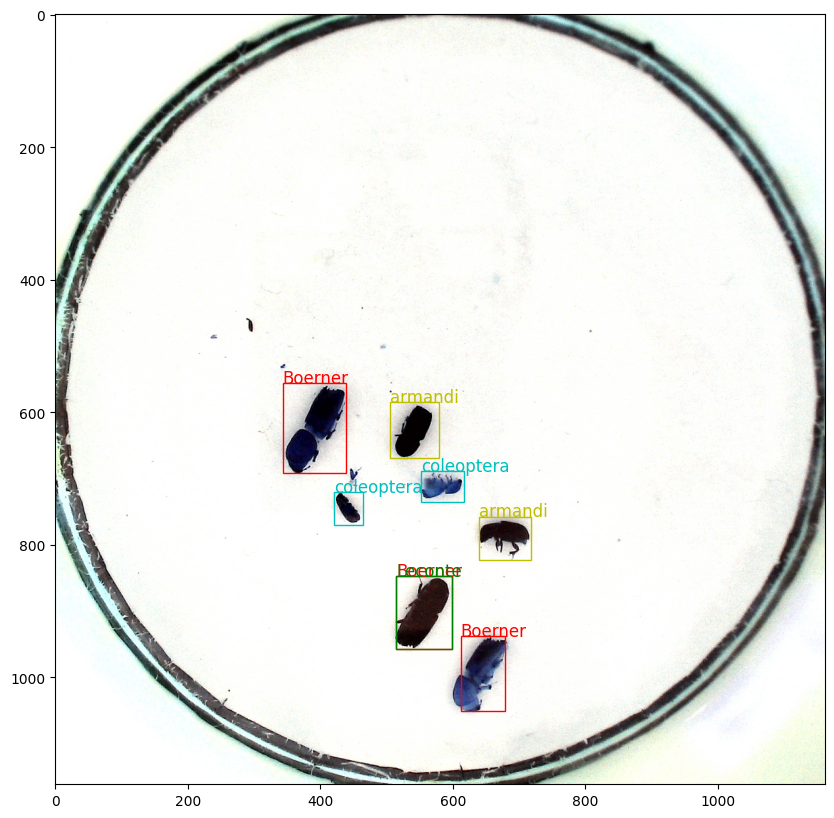

In [57]:
draw_results(total_results[20]['results'][0], '/home/aistudio/work/insects/test/images/'+str(total_results[20]['img_name'][0])+'.jpeg', draw_thresh=0.3)